In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

2023-07-25 15:57:20.357505: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-25 15:57:20.441397: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-25 15:57:20.443938: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 15:57:22.941751: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.show()

In [3]:
from unsupervised_llamas.label_scripts.spline_creator import get_horizontal_values_for_four_lanes
import tensorflow as tf
import numpy as np
import json
import os
import cv2
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


LLAMAS_SHAPE = (717, 1276)
DTYPE = tf.float32

def resize_img(img, shape):
    w = img.shape[1]
    h = img.shape[0]
    
    ratio = shape[1] / shape[0]
    
    tgt = img[h-int(w/ratio):h,0:w]
    tgt = cv2.resize(tgt, (shape[1], shape[0]))
    return tgt.astype(np.float32) / 255
    #return tgt
    
class LlamasDS:
    def __init__(self, cls_shape, image_shape):
        self.cls_shape = cls_shape
        self.image_shape = image_shape
        
    def load_image(self, file):
        file = file.numpy().decode("utf-8")

        with open(file, 'r') as fp:
            meta = json.load(fp)
        image_path = os.path.dirname(file)
        image_path = image_path.replace('/labels/', '/color_images/')
        img_name = meta['image_name'] + '_color_rect.png'
        fname = os.path.join(image_path, img_name)
        # print(fname)
        img = cv2.imread(fname)
        
        return img
    
    def read_image(self, file):
        img = self.load_image(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        return resize_img(img, self.image_shape)

    def generate_grid_llamas(self, file):
        #img = self.load_image(file)
        file = file.numpy().decode("utf-8")
        lanes = get_horizontal_values_for_four_lanes(file)
        lanes = np.array(lanes)
        
        gt = np.zeros(self.cls_shape)
        
        #return generate_grid([lines[1], lines[2]], self.cls_shape, img.shape, self.image_shape)
    
        for y in range(self.cls_shape[1]):
            yf = y / self.cls_shape[1]
            ly = int(lanes.shape[1] * yf)

            lx = lanes.T[ly,:]

            invalids = np.where(lx == -1)

            xf = lx / LLAMAS_SHAPE[1]
            x = np.round(xf * self.cls_shape[0]-1).astype(np.int64)

            x[invalids] = self.cls_shape[0]-1

            # delete unused lanes
            x = np.delete(x, (0,3))

            for i in range(len(x)):
                gt[x[i],y,i] = 1
        
        return gt

    def process_json(self, json):
        img = tf.py_function(self.read_image, [json], Tout=DTYPE)
        grid = tf.py_function(self.generate_grid_llamas, [json], Tout=DTYPE)

        img = tf.reshape(img, shape=self.image_shape)
        grid = tf.reshape(grid, shape=self.cls_shape)
        return img, grid


In [4]:
# BASE_PATH = '../../llamas/labels/'
BASE_PATH = '../../data/labels/'
PARALLEL_JOBS = 4

NUM_LANES = 2
INPUT_SHAPE = (288, 800, 3)
CLS_SHAPE = (100, 20, NUM_LANES)

SHUFFLE_SIZE = 100000
TAKE_LLAMAS_MAX = 1024

llds = LlamasDS(CLS_SHAPE, INPUT_SHAPE)

llamas_train_ds = tf.data.Dataset.list_files(os.path.join(BASE_PATH, 'train', '*/*.json'))
llamas_valid_ds = tf.data.Dataset.list_files(os.path.join(BASE_PATH, 'valid', '*/*.json'))

llamas_train_ds = llamas_train_ds.shuffle(SHUFFLE_SIZE)
llamas_train_ds = llamas_train_ds.take(TAKE_LLAMAS_MAX)
llamas_train_ds = llamas_train_ds.map(llds.process_json, num_parallel_calls=PARALLEL_JOBS)

llamas_validtest_ds = llamas_valid_ds.shuffle(SHUFFLE_SIZE)
llamas_validtest_ds = llamas_valid_ds.take(TAKE_LLAMAS_MAX)
llamas_valid_ds = llamas_valid_ds.shard(num_shards=2, index=0)
llamas_test_ds = llamas_valid_ds.shard(num_shards=2, index=1)

llamas_valid_ds = llamas_valid_ds.map(llds.process_json, num_parallel_calls=PARALLEL_JOBS)
llamas_test_ds = llamas_test_ds.map(llds.process_json, num_parallel_calls=PARALLEL_JOBS)

In [5]:
# llamas_test_ds.take(1)

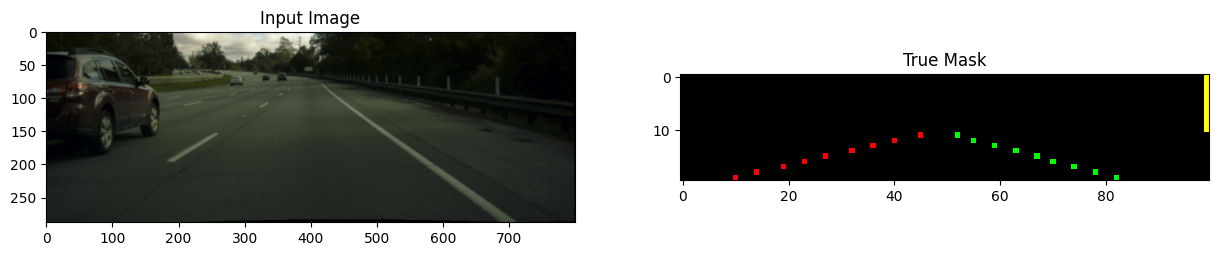

In [6]:
for img, mask in llamas_test_ds.take(1):
    #mask = tf.nn.softmax(mask,axis=0)
    #print(mask[-1])
    m = tf.zeros((CLS_SHAPE[0],CLS_SHAPE[1],3-CLS_SHAPE[2]), dtype=DTYPE)
    m = tf.concat([mask, m], -1)
    display([img, np.flipud(np.rot90(m))])

In [7]:
from models.ultrafast import UltraFastNet


NUM_LANES = CLS_SHAPE[-1]

ufm = UltraFastNet(num_lanes=NUM_LANES, size=INPUT_SHAPE[0:2], cls_dim=CLS_SHAPE, use_aux=False)

In [8]:
adam = tf.keras.optimizers.Adam(
   # 4e-4
)

def focal_loss(gamma=2., alpha=4.):
    # https://www.dlology.com/blog/multi-class-classification-with-focal-loss-for-imbalanced-datasets/
    
    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        #y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        
        #y_pred = tf.nn.softmax(y_pred, axis=1)

        model_out = y_pred + epsilon
        ce = y_true * -tf.math.log(model_out)
        weight = y_true * tf.math.pow(1. - model_out, gamma)
        fl = alpha * weight * ce
        reduced_fl = tf.math.reduce_max(fl, axis=1)
        return tf.math.reduce_mean(reduced_fl)
    return focal_loss_fixed

def loss(y_true, y_pred):
    #y_pred = tf.nn.softmax(y_pred, axis=0)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    return cce(y_true, y_pred)

ufm.compile(optimizer=adam, loss=focal_loss(), metrics=['accuracy'])
ufm.summary()

Model: "ultra_fast_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 backbone (Backbone)         multiple                  11190912  
                                                                 
 cls (Sequential)            (None, 4000)              11884448  
                                                                 
 pool (Conv2D)               multiple                  4104      
                                                                 
 softmax (Softmax)           multiple                  0         
                                                                 
Total params: 23079464 (88.04 MB)
Trainable params: 23069864 (88.00 MB)
Non-trainable params: 9600 (37.50 KB)
_________________________________________________________________


In [9]:
EPOCHS = 2
BATCH_SIZE = 8
PREFETCH_SIZE = 100

train_ds = llamas_train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(PREFETCH_SIZE)

valid_ds = llamas_valid_ds.take(int(TAKE_LLAMAS_MAX * 0.3)).batch(BATCH_SIZE)
valid_ds = valid_ds.prefetch(PREFETCH_SIZE)

history = ufm.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS, verbose=1)

Epoch 1/2
128/128 [==============================] - 1324s 10s/step - loss: 4.7800 - accuracy: 0.5095 - val_loss: 4.5850 - val_accuracy: 0.5116
Epoch 2/2
128/128 [==============================] - 1317s 10s/step - loss: 3.5028 - accuracy: 0.4968 - val_loss: 3.0329 - val_accuracy: 0.4871


1/1 [==============================] - 1s 837ms/step
1.027742624282837
tf.Tensor(0.99197495, shape=(), dtype=float32) tf.Tensor(40.0, shape=(), dtype=float32)


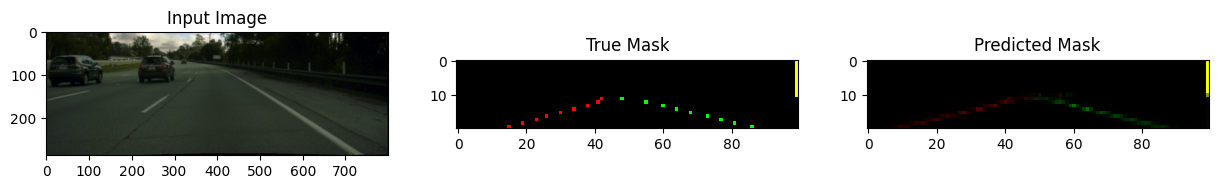

1/1 [==============================] - 0s 296ms/step
0.36704373359680176
tf.Tensor(0.99982333, shape=(), dtype=float32) tf.Tensor(40.0, shape=(), dtype=float32)


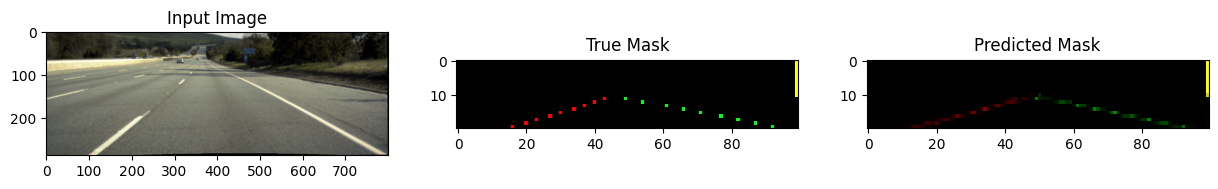

1/1 [==============================] - 0s 311ms/step
0.3811318874359131
tf.Tensor(0.9993132, shape=(), dtype=float32) tf.Tensor(40.0, shape=(), dtype=float32)


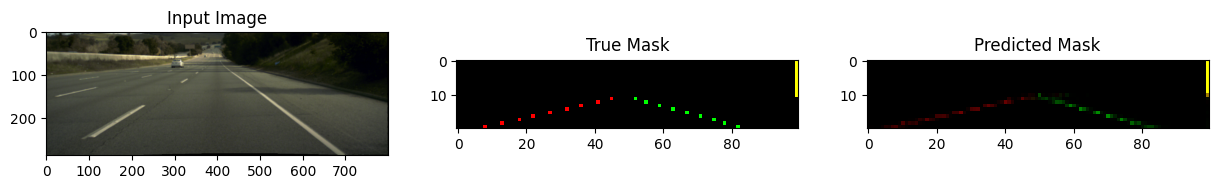

1/1 [==============================] - 0s 302ms/step
0.38085436820983887
tf.Tensor(0.99989897, shape=(), dtype=float32) tf.Tensor(40.0, shape=(), dtype=float32)


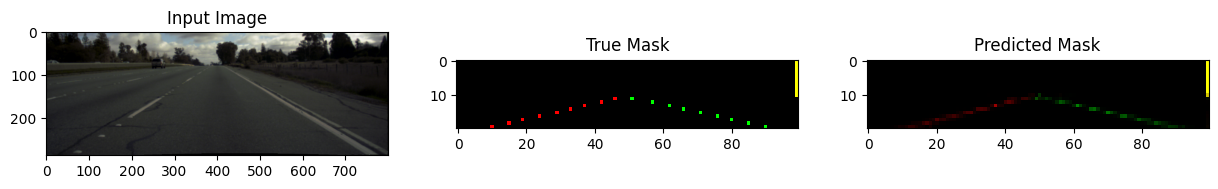

1/1 [==============================] - 0s 312ms/step
0.3576171398162842
tf.Tensor(0.99706006, shape=(), dtype=float32) tf.Tensor(40.0, shape=(), dtype=float32)


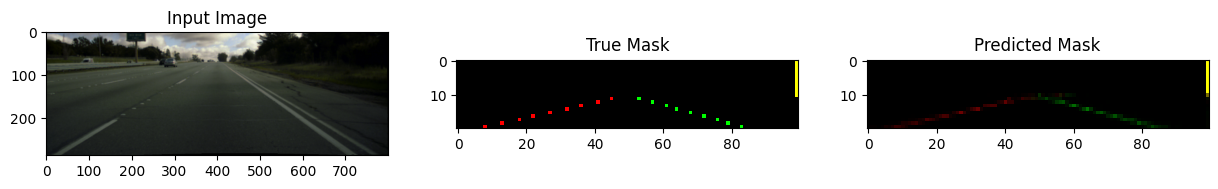

In [10]:
for img, mask in llamas_test_ds.take(5):
    s = time.time()
    pred = ufm.predict(tf.expand_dims(img, axis=0))
    e = time.time()
    
    print(e-s)
    
    pred = pred[0]
    
    #pred = tf.nn.softmax(pred, axis=1)
    print(tf.math.reduce_max(pred), tf.math.reduce_sum(pred))
    #print(pred)
    m = tf.zeros((CLS_SHAPE[0],CLS_SHAPE[1],3-CLS_SHAPE[2]), dtype=DTYPE)
    m = tf.concat([pred, m], -1)
    
    m2 = tf.zeros((CLS_SHAPE[0],CLS_SHAPE[1],3-CLS_SHAPE[2]), dtype=DTYPE)
    m2 = tf.concat([mask, m2], -1)
    
    display([img, np.flipud(np.rot90(m2)), np.flipud(np.rot90(m))])
    #print(tf.math.reduce_sum(m))
    #l = tf.keras.losses.categorical_crossentropy(mask, pred)
    #print(tf.math.reduce_sum(l))

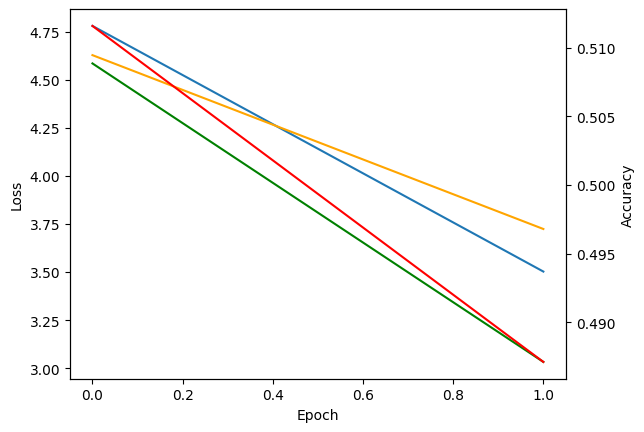

In [11]:
y_loss = history.history['loss']
y_accuracy = history.history['accuracy']
y_valloss = history.history['val_loss']
y_valaccuracy = history.history['val_accuracy']

fig, ax1 = plt.subplots()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(range(EPOCHS), y_loss)
ax1.plot(range(EPOCHS), y_valloss, color='green')
ax2 = ax1.twinx() 
ax2.set_ylabel('Accuracy')
ax2.plot(range(EPOCHS), y_accuracy, color='orange')
ax2.plot(range(EPOCHS), y_valaccuracy, color='red')